In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import h3
import h3pandas
from joblib import Parallel, delayed
import json
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [112]:
# !pip install mlflow
!mlflow server --host 127.0.0.1 --port 8080

^C


In [114]:
import mlflow

In [124]:
mlflow.set_experiment("FFS")

2024/06/06 21:33:41 INFO mlflow.tracking.fluent: Experiment with name 'FFS' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/morka/OneDrive/Pulpit/semestr%208/bike-paths-analysis/mlruns/496891559716138708', creation_time=1717702421291, experiment_id='496891559716138708', last_update_time=1717702421291, lifecycle_stage='active', name='FFS', tags={}>

In [130]:
mlflow.sklearn.autolog(disable=True)

In [2]:
COLS_TO_DROP = [
    "bbox_north",
    "bbox_south",
    "bbox_east",
    "bbox_west",
    "place_id",
    "osm_type",
    "osm_id",
    "lat",
    "lon",
    "class",
    "type",
    "place_rank",
    "importance",
    "addresstype",
    "name",
    "display_name",
    "index",
]
HEX_RESOLUTION = 8

In [3]:
amsterdam_bike_paths = gpd.read_parquet(
    "data/inputs/amsterdam_bike_paths_extended.parquet"
)

In [33]:
amsterdam_gdf.h3.polyfill_resample(7).shape

(49, 18)

<AxesSubplot: >

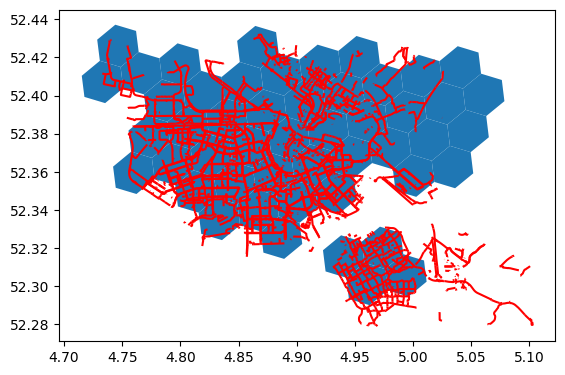

In [5]:
amsterdam_gdf = ox.geocode_to_gdf({"city": "Amsterdam"})
fig, ax = plt.subplots(1, 1)
amsterdam_gdf.h3.polyfill_resample(7).plot(ax=ax)
amsterdam_bike_paths.plot(ax=ax, color="red")

In [43]:
polygons = amsterdam_gdf.h3.polyfill_resample(8)
polygons = polygons.drop(COLS_TO_DROP, axis=1)

# amsterdam_gdf = amsterdam_gdf.to_crs(28992)
# polygons = polygons.to_crs(28992)

<AxesSubplot: >

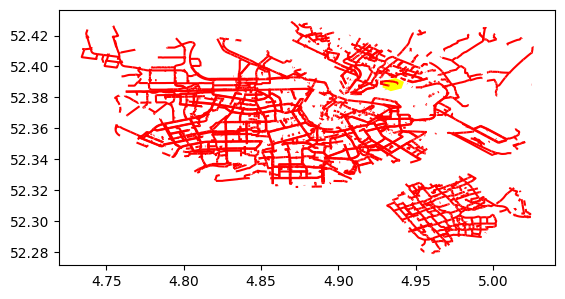

In [6]:
fig, ax = plt.subplots(1, 1)
gpd.clip(amsterdam_bike_paths, polygons).plot(ax=ax, color="red", zorder=3)
gpd.GeoSeries([polygons.iloc[175]["geometry"]]).plot(ax=ax, zorder=1, color="yellow")

In [12]:
stop

NameError: name 'stop' is not defined

In [ ]:
# way - line
# node - point

<AxesSubplot: >

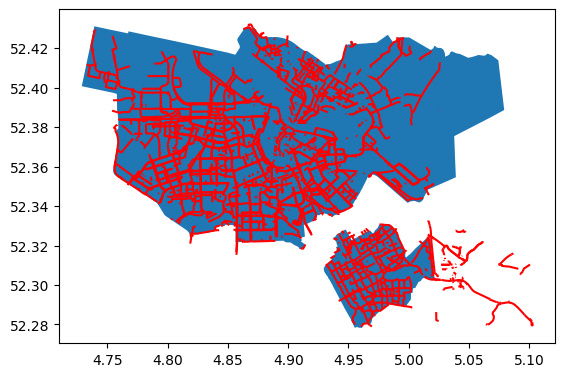

In [7]:
amsterdam_gdf = ox.geocode_to_gdf({"city": "Amsterdam"})
fig, ax = plt.subplots(1, 1)
amsterdam_gdf.plot(ax=ax)
amsterdam_bike_paths.plot(ax=ax, color="red")
# polygons[polygons["green_area_abs"]==0]["geometry"].plot(ax=ax, color="orange")
# polygons[polygons["num_buildings"]==15]["geometry"].plot(ax=ax, color="pink")

In [ ]:
with open("config/amt_columns_binning_config.json") as json_config:
    AMT_VARS_DICT = json.load(json_config)

with open("config/area_columns_binning_config.json") as json_config:
    AREA_VARS_DICT = json.load(json_config)

with open("config/len_columns_binning_config.json") as json_config:
    LEN_VARS_DICT = json.load(json_config)

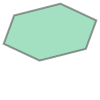

In [16]:
polygons["geometry"].iloc[0]

<AxesSubplot: >

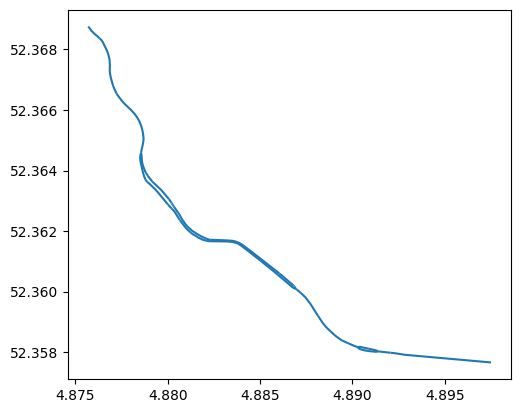

In [24]:
# ox.features.features_from_place({'city': 'Amsterdam'}, LEN_VARS_DICT["primary_roads"])["geometry"]
gpd.clip(
    ox.features.features_from_place(
        {"city": "Amsterdam"}, LEN_VARS_DICT["primary_roads"]
    )["geometry"],
    polygons["geometry"].iloc[3],
).plot()

In [90]:
%%time

AMSTERDAM_CRS = 3035


def get_features_from_place(place_query, tags_dict):
    return ox.features.features_from_place(place_query, tags_dict)


def convert_crs(gdf, crs=DEFAULT_CRS):
    return gdf.to_crs(crs)


def clip_gdf(to_clip, mask):
    return gpd.clip(to_clip, mask)


def clip_gdf_and_convert_crs(gdf, mask):
    return convert_crs(clip_gdf(gdf, mask))


def get_sum_wrapper(func):
    def inner(*args, **kwargs):
        gdf_polygons_attrs = func(*args, **kwargs)
        return np.sum(gdf_polygons_attrs)

    return inner


@get_sum_wrapper
def calculate_feat_area_within_polygon(polygon, features):
    return clip_gdf_and_convert_crs(features, polygon).area


@get_sum_wrapper
def calculate_feat_len_within_polygon(polygon, features):
    return clip_gdf_and_convert_crs(features, polygon).length


def calculate_feat_amt_within_polygon(polygon, features):
    return clip_gdf_and_convert_crs(features, polygon).shape[0]


def apply_calculations(
    polygons,
    kind,
    query,
    vars_dict=None,
    features=None,
    features_colname=None,
):
    if vars_dict is None and features is None:
        raise ValueError("Either 'vars_dict' or 'features' must be provided.")

    kind_func_mapping = {
        "amt": calculate_feat_amt_within_polygon,
        "area": calculate_feat_area_within_polygon,
        "len": calculate_feat_len_within_polygon,
    }

    func_to_use = kind_func_mapping[kind]
    if vars_dict:
        for tag_key, tags_dict in vars_dict.items():
            features = get_features_from_place(query, tags_dict)
            polygons[f"{tag_key}_{kind}"] = polygons["geometry"].apply(
                func_to_use, args=(features,)
            )
        return
    polygons[features_colname] = polygons["geometry"].apply(
        func_to_use, args=(features,)
    )
    return polygons


# polygons = apply_calculations(polygons, calculate_feat_amt_within_polygon, "amt", {"city": "Amsterdam"}, vars_dict=AMT_VARS_DICT)
# print(1)
# polygons = apply_calculations(polygons, calculate_feat_area_within_polygon, "area", {"city": "Amsterdam"}, vars_dict=AREA_VARS_DICT)
# print(2)
# apply_calculations(polygons, calculate_feat_len_within_polygon, "len", {"city": "Amsterdam"}, vars_dict=LEN_VARS_DICT)
# print(3)
apply_calculations(
    polygons,
    "len",
    {"city": "Amsterdam"},
    features=amsterdam_bike_paths,
    features_colname="bike_paths_len",
)
print(4)

# for tag_key, tags_dict in AMT_VARS_DICT.items():
#     features = get_features_from_place({'city': 'Amsterdam'}, tags_dict)
#     polygons[f"{tag_key}_amt"] = polygons["geometry"].apply(calculate_tag_amt, args=(features,))

# for tag_key, tags_dict in AREA_VARS_DICT.items():
#     features = get_features_from_place({'city': 'Amsterdam'}, tags_dict)
#     polygons[f"{tag_key}_area"] = polygons["geometry"].apply(calculate_tag_area, args=(features,))

# for tag_key, tags_dict in LEN_VARS_DICT.items():
#     features = get_features_from_place({'city': 'Amsterdam'}, tags_dict)
#     polygons[f"{tag_key}_len"] = polygons["geometry"].apply(calculate_tag_len, args=(features,))

# polygons["bike_paths_len"] =  polygons["geometry"].apply(calculate_tag_len, args=(amsterdam_bike_paths,))

4
CPU times: total: 2.66 s
Wall time: 2.77 s


In [59]:
# import gc
# gc.get_objects()
def get_predictors(data, to_predict):
    print()
    return [
        col
        for col in data.select_dtypes(include=[np.number]).columns
        if to_predict not in col
    ]


get_predictors(polygons, "bike_paths_len")

['bicycle_related_amenities_amt',
 'academia_related_amenities_amt',
 'public_services_amenities_amt',
 'leisure_and_entertainment_amenities_amt',
 'parkings_amt',
 'schools_amt',
 'atms_amt',
 'fountains_amt',
 'benches_amt',
 'camping_related_objects_amt',
 'tourism_related_objects_amt',
 'picnic_sites_amt',
 'viewpoints_amt',
 'crossings_amt',
 'traffic_signals_amt',
 'buildings_amt',
 'green_space_area',
 'buildings_area',
 'water_bodies_area',
 'primary_roads_len',
 'secondary_roads_len',
 'residential_roads_len',
 'unclassified_roads_len',
 'pedestrian_roads_len']

In [35]:
polygons_slow = gpd.read_parquet("data/output/amsterdam_h3_processed.parquet")

In [11]:
%%time

for tag_key, tags_dict in AMT_VARS_DICT.items():
    features = get_features_from_place({"city": "Amsterdam"}, tags_dict)
    polygons[f"{tag_key}_amt"] = polygons["geometry"].apply(
        calculate_tag_amt, args=(features,)
    )

for tag_key, tags_dict in AREA_VARS_DICT.items():
    features = get_features_from_place({"city": "Amsterdam"}, tags_dict)
    polygons[f"{tag_key}_area"] = polygons["geometry"].apply(
        calculate_tag_area, args=(features,)
    )

for tag_key, tags_dict in LEN_VARS_DICT.items():
    features = get_features_from_place({"city": "Amsterdam"}, tags_dict)
    polygons[f"{tag_key}_len"] = polygons["geometry"].apply(
        calculate_tag_len, args=(features,)
    )

polygons["bike_paths_len"] = polygons["geometry"].apply(
    calculate_tag_len, args=(amsterdam_bike_paths,)
)

CPU times: total: 2min 1s
Wall time: 2min 2s


In [55]:
%%time

# CPU times: total: 54.7 s
# Wall time: 6min 55s

# with Parallel(n_jobs=-1, verbose=True) as parallel:
#     for tag_key, tags_dict in AMT_VARS_DICT.items():
#         features = get_features_from_place({'city': 'Amsterdam'}, tags_dict)
#         polygons[f"{tag_key}_amt"] = parallel(delayed(calculate_tag_amt)(polygon, features) for polygon in polygons["geometry"])

#     for tag_key, tags_dict in AREA_VARS_DICT.items():
#         print(tag_key)
#         polygons[f"{tag_key}_area"] = parallel(delayed(calculate_tag_area)(polygon, tags_dict) for polygon in polygons["geometry"])

#     for tag_key, tags_dict in LEN_VARS_DICT.items():
#         print(tag_key)
#         polygons[f"{tag_key}_len"] = parallel(delayed(calculate_tag_len)(polygon, tags_dict) for polygon in polygons["geometry"])

# polygons["bike_paths_len"] = parallel(delayed(get_bike_paths_len)(polygon, amsterdam_bike_paths) for polygon in polygons["geometry"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  49 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend 

CPU times: total: 1min 55s
Wall time: 2min 4s


[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:  1.6min finished


In [116]:
def get_logged_variables(data, predictors):
    return data[predictors].apply(lambda value: np.log(value + 1))


def get_powered_variables(data, power):
    return data.apply(lambda value: value**power)


def get_inverse_variables(data, predictors, epsilon=1e-10):
    return data[predictors].apply(lambda value: 1 / (value + epsilon))

In [117]:
predictors = [
    col
    for col in polygons.select_dtypes(include=[np.number]).columns
    if "bike_paths" not in col
]

In [125]:
# polygons_ams = gpd.read_parquet("data/output/amsterdam_h3_processed.parquet")
# polygons_krk = gpd.read_parquet("data/output/krakow_h3_processed.parquet")
polygons_ams = polygons.copy()
polygons_ams[[p + "_log" for p in predictors]] = get_logged_variables(
    polygons_ams, predictors
)
polygons_ams[[p + "_pow2" for p in predictors]] = get_powered_variables(
    polygons_ams[predictors], 2
)
polygons_ams[[p + "_sqrt" for p in predictors]] = get_powered_variables(
    polygons_ams[predictors], 0.5
)
polygons_ams[[p + "_inv" for p in predictors]] = get_inverse_variables(
    polygons_ams, predictors
)

# polygons_krk[[p+"_log" for p in predictors]] = get_logged_variables(polygons_krk, predictors)
# polygons_krk[[p+"_pow2" for p in predictors]] = get_powered_variables(polygons_krk[predictors], 2)
# polygons_krk[[p+"_sqrt" for p in predictors]] = get_powered_variables(polygons_krk[predictors], 0.5)
# polygons_krk[[p+"_inv" for p in predictors]] = get_inverse_variables(polygons_krk, predictors)

In [225]:
numerical_cols = [
    col
    for col in polygons_ams.select_dtypes(include=[np.number]).columns
    if "bike_paths" not in col
]

polygons_ams[[col + "_log" for col in numerical_cols]] = polygons_ams[
    numerical_cols
].apply(lambda x: np.log(x + 1))
polygons_krk[[col + "_log" for col in numerical_cols]] = polygons_krk[
    numerical_cols
].apply(lambda x: np.log(x + 1))

print(polygons_ams.columns)

Index(['geometry', 'bicycle_related_amenities_amt',
       'academia_related_amenities_amt', 'public_services_amenities_amt',
       'leisure_and_entertainment_amenities_amt', 'parkings_amt',
       'schools_amt', 'atms_amt', 'fountains_amt', 'benches_amt',
       'camping_related_objects_amt', 'tourism_related_objects_amt',
       'picnic_sites_amt', 'viewpoints_amt', 'crossings_amt',
       'traffic_signals_amt', 'buildings_amt', 'green_space_area',
       'buildings_area', 'water_bodies_area', 'primary_roads_len',
       'secondary_roads_len', 'residential_roads_len',
       'unclassified_roads_len', 'pedestrian_roads_len', 'bike_paths_len',
       'bicycle_related_amenities_amt_log',
       'academia_related_amenities_amt_log',
       'public_services_amenities_amt_log',
       'leisure_and_entertainment_amenities_amt_log', 'parkings_amt_log',
       'schools_amt_log', 'atms_amt_log', 'fountains_amt_log',
       'benches_amt_log', 'camping_related_objects_amt_log',
       'tourism_

<AxesSubplot: >

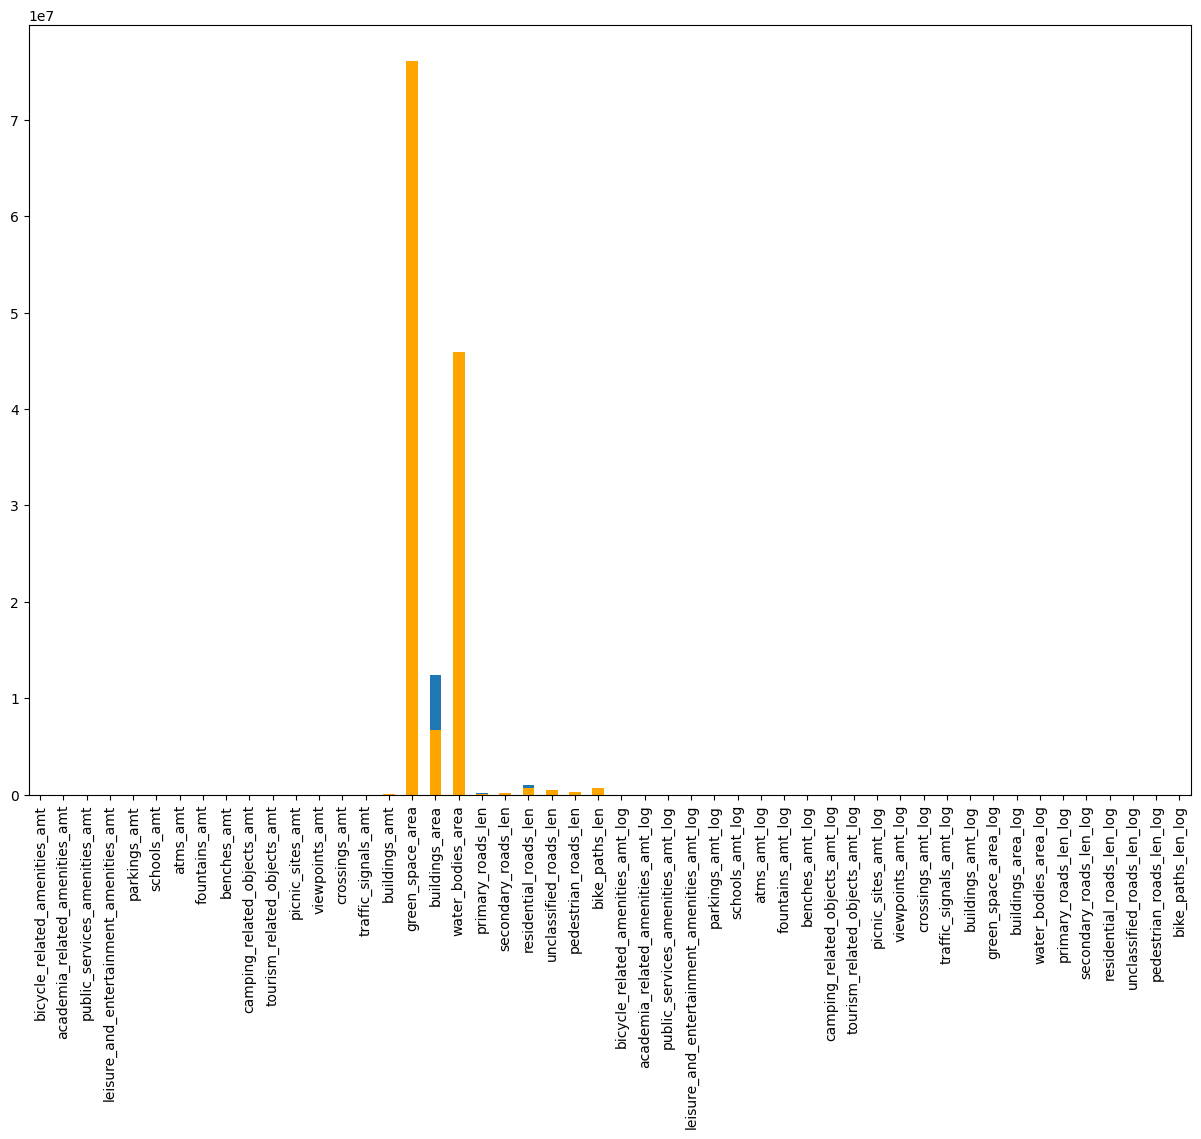

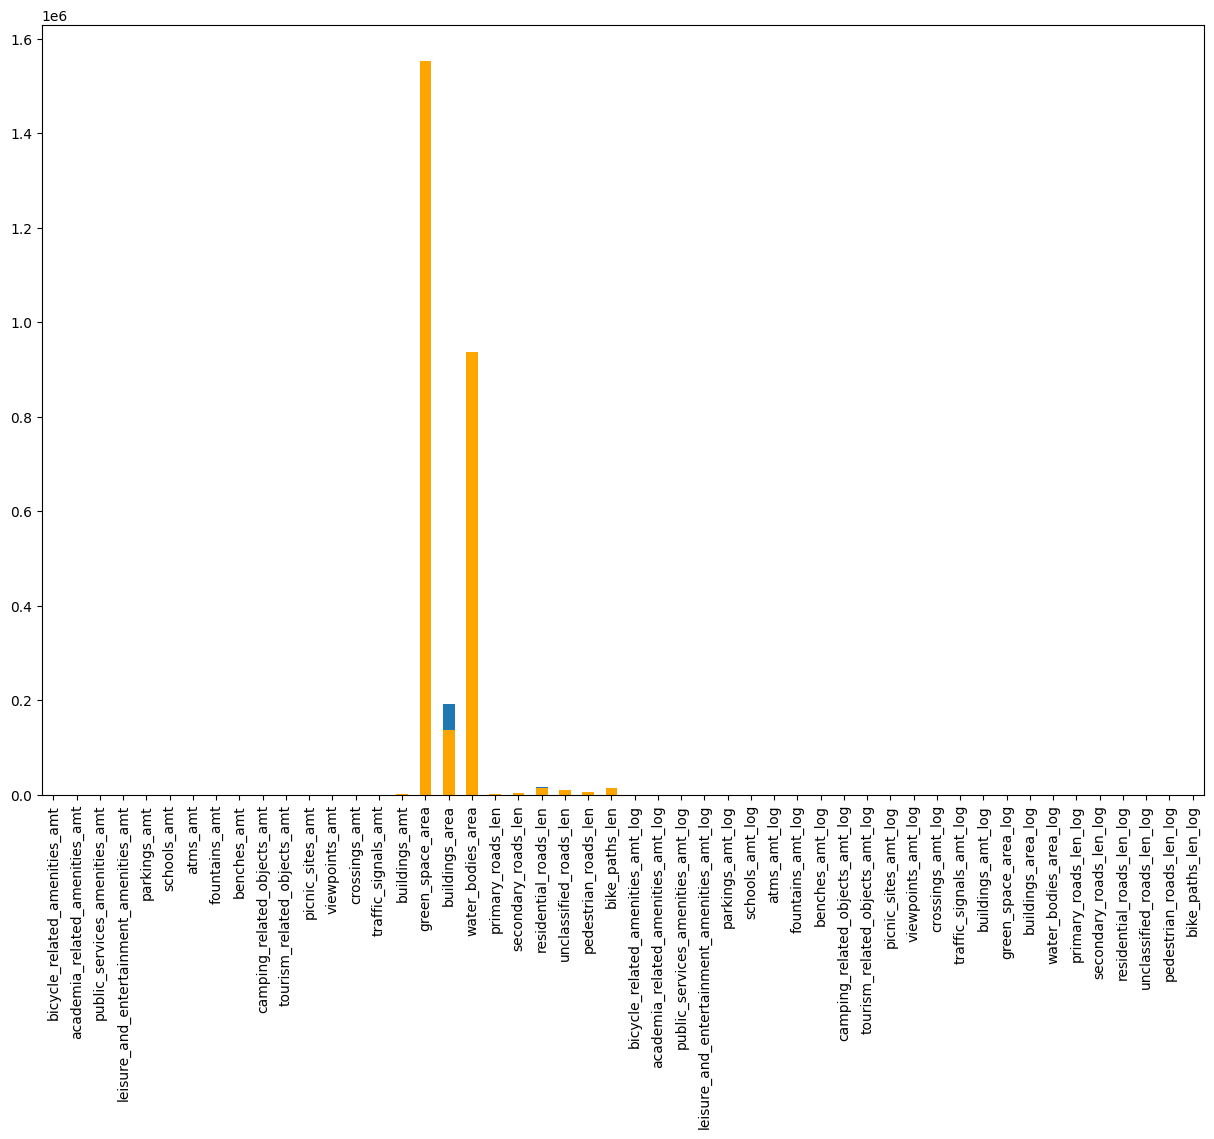

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
polygons_krk.sum(numeric_only=True, axis=0).plot(kind="bar", ax=ax)
polygons_ams.sum(numeric_only=True, axis=0).plot(kind="bar", ax=ax, color="orange")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
polygons_krk.mean(numeric_only=True, axis=0).plot(kind="bar", ax=ax)
polygons_ams.mean(numeric_only=True, axis=0).plot(kind="bar", ax=ax, color="orange")

In [219]:
# from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.neighbors import KNeighborsClassifier

# X =  polygons_ams.drop(["geometry", "bike_paths_len"], axis=1)

# y = polygons_ams["bike_paths_len"]

# X_temp, X_holdout, y_temp, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# model = LinearRegression()
# with mlflow.start_run():
#     mlflow.sklearn.autolog()
#     sfs = SequentialFeatureSelector(model, n_features_to_select=5, cv=5, scoring='neg_mean_squared_error')
#     sfs.fit(pd.concat([X_train[features], X_test[features]]), np.array(pd.concat([y_train, y_test])))
#     mlflow.sklearn.autolog(disable=True)
# print(list(sfs.get_feature_names_out()))

# # sfs = SequentialFeatureSelector(model, n_features_to_select=3)
# # sfs.fit(X_test, y_test)
# # print(sfs.get_feature_names_out())

In [217]:
mlflow.get_run("825a1420a93b48d6acba567ea6a51c45").info

<RunInfo: artifact_uri='file:///C:/Users/morka/OneDrive/Pulpit/semestr%208/bike-paths-analysis/mlruns/496891559716138708/825a1420a93b48d6acba567ea6a51c45/artifacts', end_time=1717708335827, experiment_id='496891559716138708', lifecycle_stage='active', run_id='825a1420a93b48d6acba567ea6a51c45', run_name='stately-skink-425', run_uuid='825a1420a93b48d6acba567ea6a51c45', start_time=1717707973223, status='FAILED', user_id='morka'>

In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from mlflow.models import infer_signature

# mlflow.sklearn.autolog(disable=True)
X = polygons_ams.drop(["geometry", "bike_paths_len"], axis=1).astype(float)

y = polygons_ams["bike_paths_len"].astype(float)

X_temp, X_holdout, y_temp, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)


def forward_feature_selection(X_train, y_train, X_test, y_test, log_mlflow=False):
    # initial_features = []
    remaining_features = list(X_train.columns)
    best_features = []
    best_score = float("inf")

    # for n in range(20):
    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            features = best_features + [candidate]
            model = LinearRegression()
            model.fit(X_train[features], y_train)
            y_pred = model.predict(X_test[features])
            mse_scores = -cross_val_score(
                model,
                pd.concat([X_train[features], X_test[features]]),
                pd.concat([y_train, y_test]),
                scoring="neg_mean_squared_error",
            )
            score = np.mean(mse_scores)
            # score = mean_squared_error(y_test, y_pred)
            # print(score)
            scores_with_candidates.append((score, candidate))
            if log_mlflow:
                signature = infer_signature(X_test[features], y_pred)
                with mlflow.start_run():
                    mlflow.log_param("predictors", features)
                    mlflow.log_metrics({"mse": score})
                    info = mlflow.sklearn.log_model(
                        sk_model=model,
                        artifact_path="sklearn-model",
                        signature=signature,
                        registered_model_name="sk-learn-linear-reg-model-3",
                    )
            # print(info.run_id)

        scores_with_candidates.sort()
        best_score, best_candidate = scores_with_candidates[0]

        remaining_features.remove(best_candidate)
        best_features.append(best_candidate)

        print(f"Added {best_candidate} with score {best_score}")
        # return

    return best_features


best_features = forward_feature_selection(X_train, y_train, X_test, y_test)
print("Best features:", best_features)

Added crossings_amt_sqrt with score 26956508.609047603
Added buildings_amt_log with score 21599207.469229393
Added secondary_roads_len with score 19171568.035759334
Added primary_roads_len_log with score 17248380.054875515
Added buildings_area_log with score 15358612.731615592
Added public_services_amenities_amt_inv with score 13420341.46503089
Added secondary_roads_len_sqrt with score 12479934.191316027
Added traffic_signals_amt_inv with score 10744869.950453237
Added water_bodies_area_inv with score 10408955.695350002
Added primary_roads_len_inv with score 10083756.380911497
Added benches_amt_inv with score 9864383.254261797
Added fountains_amt_log with score 9839442.337064091
Added residential_roads_len_pow2 with score 9113094.17724337
Added camping_related_objects_amt_log with score 9145531.536549795
Added viewpoints_amt_inv with score 9430008.547467161
Added schools_amt_log with score 9714070.25821176
Added bicycle_related_amenities_amt_log with score 8624006.93083332
Added campin

KeyboardInterrupt: 

In [ ]:
[
    "crossings_amt_sqrt",
    "buildings_amt_log",
    "pedestrian_roads_len_pow",
    "pedestrian_roads_len_sqrt",
    "residential_roads_len",
]

[
    "crossings_amt_sqrt",
    "buildings_amt_log",
    "secondary_roads_len",
    "primary_roads_len_log",
    "buildings_area_log",
]

In [246]:
[c for c in X_train.columns if "ped" in c]

['pedestrian_roads_len',
 'pedestrian_roads_len_log',
 'pedestrian_roads_len_pow2',
 'pedestrian_roads_len_sqrt',
 'pedestrian_roads_len_inv']

In [261]:
polygons_ams["geometry"].to_crs(28992).area.max() / 1000 / 1000, polygons_ams[
    "bike_paths_len"
].max() / 1000, polygons_ams["bike_paths_len"].min(),

(4.34914920821431, 37.064931270035714, 0.0)

In [130]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

X = polygons_ams.drop(["geometry", "bike_paths_len"], axis=1)

y = polygons_ams["bike_paths_len"]

X_temp, X_holdout, y_temp, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

# features =   ['schools_amt', 'crossings_amt', 'primary_roads_len', 'secondary_roads_len', 'residential_roads_len']
# SKLEARN: (16164782.550052637, 0.5061574091143597, 2975.9774468988626, 0.961554433943322)
# features = ['buildings_amt', 'crossings_amt', 'traffic_signals_amt', 'bicycle_related_amenities_amt', 'primary_roads_len']
# MINE (no k-fold): (11908295.458001344, 0.6361953237662367, 2800.293430853192, 2.4080063911928664)
# features = ['crossings_amt', 'secondary_roads_len', 'traffic_signals_amt', 'residential_roads_len', 'parkings_amt']
# MINE (k-fold): (17262166.154911242, 0.4726317640312445, 2862.985398084333, 1.5863338968183234)
# features = ['crossings_amt_log', 'traffic_signals_amt', 'tourism_related_objects_amt', 'residential_roads_len', 'buildings_amt_log']
# MINE k-fold wth logs
# features = ["crossings_amt_sqrt",
# "buildings_amt_log",
# "pedestrian_roads_len_pow2",
# "pedestrian_roads_len_sqrt",
# "residential_roads_len",]
# Mine k-folds with trasnformations: (6228638.951206179, 0.809711810979798, 1990.6361581268102, 1.477868957748713) BEST
# After slightly changing the calculations to use df.apply():
features = [
    "crossings_amt_sqrt",
    "buildings_amt_log",
    "secondary_roads_len",
    "primary_roads_len_log",
    "buildings_area_log",
]
model = LinearRegression()
# with mlflow.start_run() as run:
model.fit(
    pd.concat([X_train[features], X_test[features]]), pd.concat([y_train, y_test])
)

y_holdout_pred = model.predict(X_holdout[features])

mse = mean_squared_error(y_holdout, y_holdout_pred)
r2 = r2_score(y_holdout, y_holdout_pred)
mae = mean_absolute_error(y_holdout, y_holdout_pred)
mape = mean_absolute_percentage_error(y_holdout, y_holdout_pred)

scores = mse, r2, mae, mape
print(scores)

(7606549.251234476, 0.9416117903397642, 2291.079677312152, 4.399137867189518e+17)


In [132]:
y_holdout, y_holdout_pred

(h3_polyfill
 871968244ffffff     2876.346299
 871969cabffffff      492.836680
 871969532ffffff    37064.931270
 871969c8effffff     6483.635510
 871969cf2ffffff        0.000000
 871969c89ffffff      280.740901
 871969c88ffffff     5972.576505
 871969c98ffffff    21494.450808
 871968268ffffff     8022.842933
 871969cd4ffffff        0.000000
 Name: bike_paths_len, dtype: float64,
 array([-1477.89737433,  2297.23410132, 33900.88185334,  2356.67967879,
         -488.40241487,  4299.42859727,  3023.73143181, 21844.04255361,
         6855.62184565,  -488.40241487]))

In [251]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

X = polygons_krk.drop(["geometry", "bike_paths_len"], axis=1)

y = polygons_krk["bike_paths_len"]

X_temp, X_holdout, y_temp, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

features = [
    "crossings_amt_sqrt",
    "buildings_amt_log",
    "pedestrian_roads_len_pow2",
    "pedestrian_roads_len_sqrt",
    "residential_roads_len",
]
# model = LinearRegression()

# model.fit(pd.concat([X_train[features], X_test[features]]), pd.concat([y_train, y_test]))

y_holdout_pred = model.predict(X_holdout[features])

mse = mean_squared_error(y_holdout, y_holdout_pred)
r2 = r2_score(y_holdout, y_holdout_pred)
mae = mean_absolute_error(y_holdout, y_holdout_pred)

scores = mse, r2, mae
print(scores)

(198843708.8623276, -20.849001473732137, 12233.225311401153)


Roznice miedzy hexami a mapa Amsterdamu

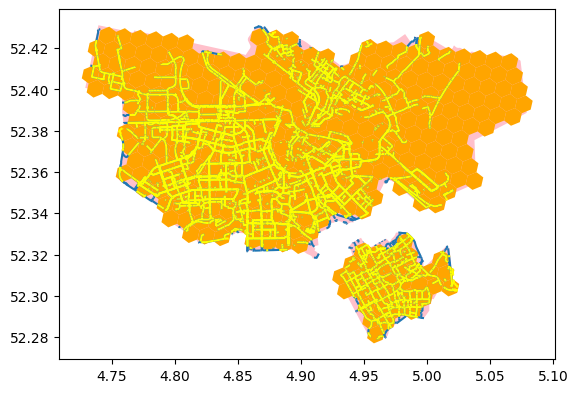

In [261]:
fig, ax = plt.subplots(1, 1)
amsterdam_gdf.plot(ax=ax, color="pink")
polygons["geometry"].plot(ax=ax, color="orange")
clipped.plot(ax=ax)
# gpd.GeoSeries(temp).plot(ax=ax, color="red")
for i in range(0, 352):
    # if len(polygon)>0:
    g = gpd.clip(amsterdam_bike_paths, polygons["geometry"].iloc[i])
    # print(len(g))
    if len(g) > 0:
        g.plot(ax=ax, color="yellow")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

X = polygons_ams.drop(["geometry", "bike_paths_len"], axis=1)
y = polygons_ams["bike_paths_len"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the models and parameter grids
models = {
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
}

param_grids = {
    "SVR": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", "auto"],
    },
    "RandomForestRegressor": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
    },
    "GradientBoostingRegressor": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7],
    },
}

# Perform grid search for each model
best_estimators = {}
for model_name in models.keys():
    grid_search = GridSearchCV(
        estimator=models[model_name],
        param_grid=param_grids[model_name],
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

# Evaluate the models on the test set
for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{model_name} MSE: {mse}")

# Output the best estimators for further use
best_estimators

In [65]:
# TESTING WORKERS

amsterdam = gpd.read_parquet("data/testing/amsterdam_h3_res_8_processed.parquet")
# amsterdam_2w = gpd.read_parquet("data/testing/amsterdam_h3_res_8_processed_2_workers.parquet")

krk = gpd.read_parquet("data/testing/krakow_h3_res_8_processed.parquet")
# krk_2w = gpd.read_parquet("data/testing/krakow_h3_res_8_processed_2_workers.parquet")

# amsterdam.equals(amsterdam_2w), krk.equals(krk_2w)
# >> (True, True)

In [70]:
polygons.sort_index().equals(amsterdam.sort_index())

False

In [97]:
amsterdam.loc["881969534bfffff"]["bike_paths_len"], polygons.loc["881969534bfffff"][
    "bike_paths_len"
]

(6678.2541962402465, 6677.093197723213)

In [94]:
np.abs(
    amsterdam[polygons.columns].drop("geometry", axis=1).sort_index()
    - polygons.drop("geometry", axis=1).sort_index()
).idxmax()

bicycle_related_amenities_amt              8819682401fffff
academia_related_amenities_amt             8819682401fffff
public_services_amenities_amt              8819682401fffff
leisure_and_entertainment_amenities_amt    8819682401fffff
parkings_amt                               8819682401fffff
schools_amt                                8819682401fffff
atms_amt                                   8819682401fffff
fountains_amt                              8819682401fffff
benches_amt                                8819682401fffff
camping_related_objects_amt                8819682401fffff
tourism_related_objects_amt                8819682401fffff
picnic_sites_amt                           8819682401fffff
viewpoints_amt                             8819682401fffff
crossings_amt                              8819682401fffff
traffic_signals_amt                        8819682401fffff
buildings_amt                              8819682401fffff
green_space_area                           8819695365fff